### Idea

Input state and data -> train against tomorrow state.

After training, generate full matrix for tomorrow by inputting all states.

Is apparently useful for inference and further finacial analysis.

It is thus time dependent.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [2]:
train_df  = pd.read_csv("dataset/train_diagnostic.csv")
labels_df = pd.read_csv("dataset/label_diagnostic.csv")

print(train_df.shape, labels_df.shape)
train_df.head()

# Rebuild forward % change from Price so that we can define bin midpoints
# Forward return at day t = (Price_{t+1} / Price_t - 1) * 100
train_df["Percent_change_forward"] = (
    train_df["Price"].shift(-1) / train_df["Price"] - 1
) * 100.0

# Drop last row where forward return is undefined
train_df = train_df.iloc[:-1].copy()
labels_df = labels_df.iloc[:-1].copy()

torch.manual_seed(42)

(2369, 198) (2369, 1)


In [3]:
# ============================================
# SOFT-LABEL CONFIGURATION
# ============================================
USE_SOFT_LABELS = True         # Set to True to enable soft-label training
SOFT_LABEL_KERNEL = "gaussian"  # "gaussian" or "triangular"
SOFT_LABEL_SIGMA = 1.0          # For gaussian kernel: controls spread
SOFT_LABEL_RADIUS = 3           # For triangular kernel: support radius
SOFT_LABEL_EPS = 1e-8           # Numerical stability for normalization

print(f"Soft-label config: enabled={USE_SOFT_LABELS}, kernel={SOFT_LABEL_KERNEL}, sigma={SOFT_LABEL_SIGMA}, radius={SOFT_LABEL_RADIUS}")

# ============================================
# AUTO-ORGANIZE OUTPUTS BY CONFIGURATION
# ============================================
import os
import json
from datetime import datetime

# Create experiment name based on configuration
if USE_SOFT_LABELS:
    if SOFT_LABEL_KERNEL == "gaussian":
        EXP_NAME = f"soft_gaussian_sigma{SOFT_LABEL_SIGMA}"
    else:  # triangular
        EXP_NAME = f"soft_triangular_radius{SOFT_LABEL_RADIUS}"
else:
    EXP_NAME = "hard_labels"

# Create output directories
RESULTS_DIR = f"results/{EXP_NAME}"
MODELS_DIR = f"{RESULTS_DIR}/models"
FIGURES_DIR = f"{RESULTS_DIR}/figures"
METRICS_DIR = f"{RESULTS_DIR}/metrics"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)

print(f"\n📁 Output directories:")
print(f"   Results: {RESULTS_DIR}/")
print(f"   Models:  {MODELS_DIR}/")
print(f"   Figures: {FIGURES_DIR}/")
print(f"   Metrics: {METRICS_DIR}/")

# Save configuration to JSON
config = {
    "experiment_name": EXP_NAME,
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "use_soft_labels": USE_SOFT_LABELS,
    "soft_label_kernel": SOFT_LABEL_KERNEL,
    "soft_label_sigma": SOFT_LABEL_SIGMA,
    "soft_label_radius": SOFT_LABEL_RADIUS,
    "soft_label_eps": SOFT_LABEL_EPS,
}

with open(f"{RESULTS_DIR}/config.json", "w") as f:
    json.dump(config, f, indent=2)

print(f"✓ Configuration saved to {RESULTS_DIR}/config.json\n")

# ============================================
# DATA PREPARATION
# ============================================

print("Original shape:", train_df.shape)

# Drop columns that contain NaNs (at least the obviously problematic ones)
cols_with_na = train_df.columns[train_df.isna().any()].tolist()
print("Columns with NaNs:", cols_with_na)

# Drop Opinion and any other columns with NaNs
train_df = train_df.drop(columns=["Opinion"], errors="ignore")
print("After dropping Opinion:", train_df.shape)

# Prepare feature columns
drop_cols = ["index", "Percent_change_forward", "Backward_Bin"]
feature_cols = [c for c in train_df.columns if c not in drop_cols]

X_all = train_df[feature_cols].values.astype(np.float32)

# States: make them 0-based for PyTorch
s_curr_all = (train_df["Backward_Bin"].values.astype(np.int64) - 1)
y_all      = (labels_df["Forward_Bin"].values.astype(np.int64) - 1)

n_samples, n_features = X_all.shape
n_states = int(max(s_curr_all.max(), y_all.max()) + 1)

print("n_samples:", n_samples)
print("n_features:", n_features)
print("n_states:", n_states)
print("✓ Data ready for training")


Soft-label config: enabled=True, kernel=gaussian, sigma=1.0, radius=3

📁 Output directories:
   Results: results/soft_gaussian_sigma1.0/
   Models:  results/soft_gaussian_sigma1.0/models/
   Figures: results/soft_gaussian_sigma1.0/figures/
   Metrics: results/soft_gaussian_sigma1.0/metrics/
✓ Configuration saved to results/soft_gaussian_sigma1.0/config.json

Original shape: (2368, 199)
Columns with NaNs: ['Opinion']
After dropping Opinion: (2368, 198)
n_samples: 2368
n_features: 195
n_states: 55
✓ Data ready for training


In [4]:
# ============================================
# SOFT-LABEL GENERATION FUNCTIONS
# ============================================

def create_soft_labels_batch(y_hard, n_states, kernel="gaussian", sigma=2.0, radius=3, eps=1e-8):
    """
    Convert hard integer labels to soft probability distributions over bins.
    
    Args:
        y_hard: (batch_size,) integer labels in [0, n_states-1]
        n_states: total number of states/bins
        kernel: "gaussian" or "triangular"
        sigma: for gaussian kernel, controls spread
        radius: for triangular kernel, support radius
        eps: numerical stability constant
    
    Returns:
        soft_targets: (batch_size, n_states) normalized probability distributions
    """
    import torch
    import numpy as np
    
    batch_size = y_hard.shape[0]
    device = y_hard.device
    dtype = torch.float32
    
    # Create indices tensor: (batch_size, n_states)
    j = torch.arange(n_states, device=device, dtype=dtype).unsqueeze(0).expand(batch_size, -1)
    y_expanded = y_hard.unsqueeze(1).float()  # (batch_size, 1)
    
    if kernel == "gaussian":
        # Gaussian kernel: q[j] ∝ exp(-(j - y)^2 / (2*sigma^2))
        distances_sq = (j - y_expanded) ** 2
        unnormalized = torch.exp(-distances_sq / (2 * sigma ** 2))
    
    elif kernel == "triangular":
        # Triangular kernel: q[j] ∝ max(0, 1 - |j - y| / (radius + 1))
        distances = torch.abs(j - y_expanded)
        unnormalized = torch.clamp(1.0 - distances / (radius + 1), min=0.0)
    
    else:
        raise ValueError(f"Unknown kernel: {kernel}. Use 'gaussian' or 'triangular'.")
    
    # Normalize to sum to 1 (with numerical stability)
    soft_targets = unnormalized / (unnormalized.sum(dim=1, keepdim=True) + eps)
    
    return soft_targets


def compute_expected_bin(probs, n_states):
    """
    Compute expected bin: sum_j p[j] * j
    
    Args:
        probs: (batch_size, n_states) probability distributions
        n_states: total number of states
    
    Returns:
        expected_bins: (batch_size,) expected bin values
    """
    device = probs.device
    bins = torch.arange(n_states, device=device, dtype=probs.dtype)
    expected_bins = (probs * bins).sum(dim=1)
    return expected_bins


def compute_bin_severity(pred_bins, true_bins):
    """
    Compute mean absolute error in bin space: |pred_bin - true_bin|
    
    Args:
        pred_bins: (batch_size,) predicted bin indices or expected bins
        true_bins: (batch_size,) true bin indices
    
    Returns:
        severity: scalar, mean absolute bin error
    """
    return torch.abs(pred_bins - true_bins.float()).mean().item()


# Sanity checks for soft-label functions
if USE_SOFT_LABELS:
    print("\n=== Soft-Label Sanity Checks ===")
    
    # Test 1: Single label at bin 27
    y_test = torch.tensor([27], dtype=torch.long)
    soft_gauss = create_soft_labels_batch(y_test, n_states, kernel="gaussian", sigma=SOFT_LABEL_SIGMA)
    soft_tri = create_soft_labels_batch(y_test, n_states, kernel="triangular", radius=SOFT_LABEL_RADIUS)
    
    print(f"Gaussian soft label for bin 27 (sigma={SOFT_LABEL_SIGMA}):")
    print(f"  Peak at bin 27: {soft_gauss[0, 27]:.4f}")
    print(f"  Bins [25-29]: {soft_gauss[0, 25:30].numpy()}")
    print(f"  Sum: {soft_gauss.sum(dim=1).item():.6f} (should be 1.0)")
    
    print(f"\nTriangular soft label for bin 27 (radius={SOFT_LABEL_RADIUS}):")
    print(f"  Peak at bin 27: {soft_tri[0, 27]:.4f}")
    print(f"  Bins [25-29]: {soft_tri[0, 25:30].numpy()}")
    print(f"  Sum: {soft_tri.sum(dim=1).item():.6f} (should be 1.0)")
    
    # Test 2: Expected bin should equal true bin for soft labels centered at true bin
    expected_bin = compute_expected_bin(soft_gauss, n_states)
    print(f"\nExpected bin from gaussian soft label: {expected_bin.item():.2f} (true: 27)")
    
    # Test 3: Batch processing
    y_batch = torch.tensor([0, 27, 54], dtype=torch.long)
    soft_batch = create_soft_labels_batch(y_batch, n_states, kernel=SOFT_LABEL_KERNEL, 
                                          sigma=SOFT_LABEL_SIGMA, radius=SOFT_LABEL_RADIUS)
    print(f"\nBatch test (bins 0, 27, 54):")
    print(f"  Shape: {soft_batch.shape} (should be (3, {n_states}))")
    print(f"  All sums close to 1.0: {torch.allclose(soft_batch.sum(dim=1), torch.ones(3), atol=1e-5)}")
    
    print("✓ Soft-label functions validated\n")



=== Soft-Label Sanity Checks ===
Gaussian soft label for bin 27 (sigma=1.0):
  Peak at bin 27: 0.3989
  Bins [25-29]: [0.05399097 0.24197073 0.3989423  0.24197073 0.05399097]
  Sum: 1.000000 (should be 1.0)

Triangular soft label for bin 27 (radius=3):
  Peak at bin 27: 0.2500
  Bins [25-29]: [0.125  0.1875 0.25   0.1875 0.125 ]
  Sum: 1.000000 (should be 1.0)

Expected bin from gaussian soft label: 27.00 (true: 27)

Batch test (bins 0, 27, 54):
  Shape: torch.Size([3, 55]) (should be (3, 55))
  All sums close to 1.0: True
✓ Soft-label functions validated



In [5]:
# Temporal split: 70 / 15 / 15
T = n_samples
train_end = int(0.7 * T)
val_end   = int(0.85 * T)

idx_train = np.arange(0,        train_end)
idx_val   = np.arange(train_end, val_end)
idx_test  = np.arange(val_end,  T)

def split(arr):
    return arr[idx_train], arr[idx_val], arr[idx_test]

X_train, X_val, X_test = split(X_all)
s_train, s_val, s_test = split(s_curr_all)
y_train, y_val, y_test = split(y_all)

# Standardize features based on *training* only
mean = X_train.mean(axis=0, keepdims=True)
std  = X_train.std(axis=0, keepdims=True) + 1e-8

X_train_std = (X_train - mean) / std
X_val_std   = (X_val   - mean) / std
X_test_std  = (X_test  - mean) / std

# Store for later (transition matrices on full data)
X_all_std = (X_all - mean) / std


In [6]:
class TransitionDataset(Dataset):
    def __init__(self, X, s_curr, s_next):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.s_curr = torch.tensor(s_curr, dtype=torch.long)
        self.s_next = torch.tensor(s_next, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.s_curr[idx], self.s_next[idx]

train_ds = TransitionDataset(X_train_std, s_train, y_train)
val_ds   = TransitionDataset(X_val_std,   s_val,   y_val)
test_ds  = TransitionDataset(X_test_std,  s_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=512, shuffle=False)


In [ ]:
class TransitionNetStateHead(nn.Module):
    """
    Trunk + State-Specific Head architecture.
    
    A shared trunk processes features F_t (WITHOUT the current state).
    Each current state s has its own linear output head mapping
    trunk output h_t to logits over next-state classes.
    
    This structurally forces state-dependent predictions:
    different starting states MUST produce different logit functions.
    """
    def __init__(self, n_features, n_states, trunk_dims=(64, 128, 256, 128), 
                 trunk_out=64, dropout=0.2):
        super().__init__()
        self.n_features = n_features
        self.n_states = n_states
        self.trunk_out = trunk_out

        # Shared trunk: processes ONLY features (no state info)
        layers = []
        in_dim = n_features
        for h in trunk_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, trunk_out))
        layers.append(nn.GELU())
        self.trunk = nn.Sequential(*layers)

        # State-specific output heads: W[s] @ h + b[s] -> logits
        # W: (n_states, trunk_out, n_states)
        # b: (n_states, n_states)
        self.head_W = nn.Parameter(torch.randn(n_states, trunk_out, n_states) * 0.01)
        self.head_b = nn.Parameter(torch.zeros(n_states, n_states))

    def forward(self, x, s_curr):
        """
        x:      (B, n_features)   — feature vectors
        s_curr: (B,)              — current state indices in [0, n_states-1]
        returns: (B, n_states)    — logits over next states
        """
        # Shared trunk: (B, n_features) -> (B, trunk_out)
        h = self.trunk(x)

        # Select state-specific head parameters
        # W_s: (B, trunk_out, n_states),  b_s: (B, n_states)
        W_s = self.head_W[s_curr]   # index into first dim with (B,) -> (B, trunk_out, n_states)
        b_s = self.head_b[s_curr]   # (B, n_states)

        # Compute logits: batched matmul h @ W_s + b_s
        # h: (B, trunk_out) -> (B, 1, trunk_out)
        # W_s: (B, trunk_out, n_states)
        # bmm result: (B, 1, n_states) -> squeeze -> (B, n_states)
        logits = torch.bmm(h.unsqueeze(1), W_s).squeeze(1) + b_s

        return logits


# Keep old class available for reference / loading old weights
class TransitionNet(nn.Module):
    def __init__(self, n_features, n_states, hidden_dims=(64,128, 256, 128, 64), dropout=0.2):
        super().__init__()
        self.n_states = n_states
        layers = []
        in_dim = n_features + n_states
        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_states)

    def forward(self, x, s_curr):
        s_onehot = F.one_hot(s_curr, num_classes=self.n_states).float()
        z = torch.cat([x, s_onehot], dim=-1)
        h = self.mlp(z)
        logits = self.out(h)
        return logits

In [ ]:
device = DEVICE

# Use new state-head architecture
# trunk_dims matches old hidden_dims[:-1], trunk_out matches old hidden_dims[-1]
model = TransitionNetStateHead(
    n_features=n_features, 
    n_states=n_states,
    trunk_dims=(64, 128, 256, 128),
    trunk_out=64,
    dropout=0.2
).to(device)

n_params = sum(p.numel() for p in model.parameters())
n_trunk = sum(p.numel() for p in model.trunk.parameters())
n_heads = model.head_W.numel() + model.head_b.numel()
print(f"Model: TransitionNetStateHead")
print(f"  Total params:  {n_params:,}")
print(f"  Trunk params:  {n_trunk:,}")
print(f"  Head params:   {n_heads:,}  (W: {tuple(model.head_W.shape)}, b: {tuple(model.head_b.shape)})")

# Class weights: inverse frequency of next-state bins
class_counts = np.bincount(y_train, minlength=n_states)
class_weights = class_counts.sum() / np.maximum(class_counts, 1)
class_weights = class_weights / class_weights.mean()  # rescale a bit
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights_t)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
def run_epoch(loader, train=True):
    if train:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    total_n = 0
    total_correct = 0
    total_severity = 0.0

    with torch.set_grad_enabled(train):
        for X_batch, s_curr_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            s_curr_batch = s_curr_batch.to(device)
            y_batch = y_batch.to(device)

            if train:
                optimizer.zero_grad()

            logits = model(X_batch, s_curr_batch)
            
            if USE_SOFT_LABELS:
                soft_targets = create_soft_labels_batch(
                    y_batch, 
                    n_states, 
                    kernel=SOFT_LABEL_KERNEL,
                    sigma=SOFT_LABEL_SIGMA, 
                    radius=SOFT_LABEL_RADIUS,
                    eps=SOFT_LABEL_EPS
                )
                log_probs = F.log_softmax(logits, dim=1)
                loss = F.kl_div(log_probs, soft_targets, reduction='batchmean')
            else:
                loss = criterion(logits, y_batch)

            if train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            batch_size = X_batch.size(0)
            total_loss += loss.item() * batch_size
            total_n    += batch_size

            preds = logits.argmax(dim=1)
            total_correct += (preds == y_batch).sum().item()

            # Always compute severity (needed for comparison across experiments)
            with torch.no_grad():
                probs = F.softmax(logits, dim=1)
                expected_bins = compute_expected_bin(probs, n_states)
                severity = compute_bin_severity(expected_bins, y_batch)
                total_severity += severity * batch_size

    avg_loss = total_loss / total_n
    avg_acc = total_correct / total_n
    avg_severity = total_severity / total_n
    
    return avg_loss, avg_acc, avg_severity

n_epochs = 40

train_losses_transition, val_losses_transition = [], []
train_severities, val_severities = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc, train_sev = run_epoch(train_loader, train=True)
    val_loss,   val_acc, val_sev   = run_epoch(val_loader,   train=False)
    train_losses_transition.append(train_loss)
    val_losses_transition.append(val_loss)
    train_severities.append(train_sev)
    val_severities.append(val_sev)

    print(
        f"Epoch {epoch:03d} | "
        f"train loss {train_loss:.4f} acc {train_acc:.3f} sev {train_sev:.2f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.3f} sev {val_sev:.2f}"
    )

test_loss, test_acc, test_sev = run_epoch(test_loader, train=False)
print(f"\nTest loss {test_loss:.4f}, test acc {test_acc:.3f}, test severity {test_sev:.2f}")

# ============================================
# SAVE TRAINING HISTORY
# ============================================
import json

history = {
    "train_losses": train_losses_transition,
    "val_losses": val_losses_transition,
    "train_severities": train_severities,
    "val_severities": val_severities,
    "test_loss": test_loss,
    "test_acc": test_acc,
    "test_severity": test_sev,
}

with open(f"{METRICS_DIR}/transition_model_history.json", "w") as f:
    json.dump(history, f, indent=2)

print(f"✓ Training history saved to {METRICS_DIR}/transition_model_history.json")


In [10]:
def build_transition_matrix_for_day(k):
    """
    k: integer index in [0, n_samples-1] (row in your CSV)
    returns: A_k of shape (n_states, n_states)
    """
    model.eval()
    x_k = torch.tensor(X_all_std[k], dtype=torch.float32, device=device)

    # Repeat the same features for each possible current state i
    x_rep = x_k.unsqueeze(0).repeat(n_states, 1)  # (n_states, n_features)
    s_curr_all = torch.arange(n_states, dtype=torch.long, device=device)

    with torch.no_grad():
        logits = model(x_rep, s_curr_all)         # (n_states, n_states)
        A_k = F.softmax(logits, dim=1)            # probabilities

    return A_k.cpu()  # (n_states, n_states)


In [11]:
k_example = 100  # pick a date by row index
A_k = build_transition_matrix_for_day(k_example)

print(A_k.shape)     # should be (n_states, n_states)
print(A_k.sum(dim=1))  # each row ~ 1.0


torch.Size([55, 55])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [12]:
# Build model-based transition matrices A_all for all k
# A_all[k] has shape (n_states, n_states)

model.eval()

A_all_list = []

with torch.no_grad():
    for k in range(n_samples):
        A_k = build_transition_matrix_for_day(k)   # (n_states, n_states)
        A_all_list.append(A_k.unsqueeze(0))        # (1, n_states, n_states)

A_all = torch.cat(A_all_list, dim=0)               # (n_samples, n_states, n_states)
print(A_all.shape)


torch.Size([2368, 55, 55])


In [13]:
# ============================================
# SAVE MODEL OUTPUTS TO CONFIG-SPECIFIC DIRECTORY
# ============================================

# Save transition matrices
torch.save(A_all, f"{MODELS_DIR}/A_all_model.pt")
np.save(f"{MODELS_DIR}/A_all_model.npy", A_all.numpy())

# Save model weights
torch.save(model.state_dict(), f"{MODELS_DIR}/model_weights.pt")

print(f"✓ Saved transition matrices to {MODELS_DIR}/A_all_model.*")
print(f"✓ Saved model weights to {MODELS_DIR}/model_weights.pt")


✓ Saved transition matrices to results/soft_gaussian_sigma1.0/models/A_all_model.*
✓ Saved model weights to results/soft_gaussian_sigma1.0/models/model_weights.pt


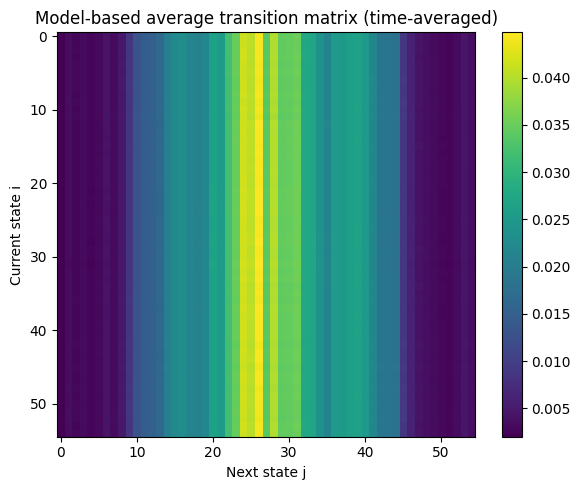

In [14]:
import matplotlib.pyplot as plt

# Average over time (k dimension)
A_mean = A_all.mean(dim=0).numpy()   # (n_states, n_states)

plt.figure(figsize=(6, 5))
im = plt.imshow(A_mean, aspect='auto')
plt.colorbar(im)
plt.xlabel("Next state j")
plt.ylabel("Current state i")
plt.title("Model-based average transition matrix (time-averaged)")
plt.tight_layout()
plt.show()


Empirical transition matrix shape: (55, 55)


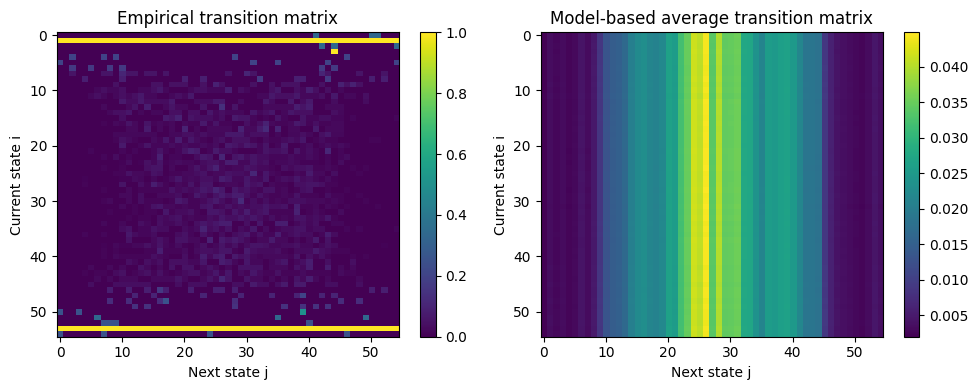

In [15]:
# You already have these:
# s_curr_all = Backward_Bin - 1
# y_all = Forward_Bin - 1
# n_states = max bin + 1

A_emp_counts = np.zeros((n_states, n_states), dtype=np.float64)

# Build counts
for i, j in zip(s_curr_all, y_all):
    A_emp_counts[i, j] += 1

# Convert to probabilities with smoothing to avoid zero-rows
A_emp = (A_emp_counts + 1e-8) / (A_emp_counts.sum(axis=1, keepdims=True) + 1e-8)

print("Empirical transition matrix shape:", A_emp.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

im0 = axes[0].imshow(A_emp, aspect='auto')
axes[0].set_title("Empirical transition matrix")
axes[0].set_xlabel("Next state j")
axes[0].set_ylabel("Current state i")
fig.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(A_mean, aspect='auto')
axes[1].set_title("Model-based average transition matrix")
axes[1].set_xlabel("Next state j")
axes[1].set_ylabel("Current state i")
fig.colorbar(im1, ax=axes[1])

plt.tight_layout()
plt.show()


Number of states: 55
bin_midpoints length: 55
First few bin_midpoints (%): [-13.01242414   0.          -8.21251676  -7.12392988  -6.56564952
  -5.32113348  -4.77689502  -4.29346412  -3.77611626  -3.22002121]
Simulated price array shape: (10, 11)


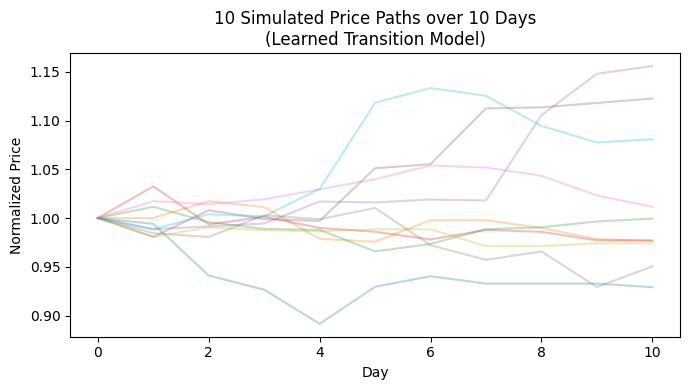

In [16]:
# ---------------------------------------------------------
# 0. BUILD BIN MIDPOINTS FROM DATA (NO GUESSING)
# ---------------------------------------------------------
# We define one representative return per state j as the
# mean of Percent_change_forward over all samples with Forward_Bin = j+1.

# Make sure these exist from earlier in the notebook:
# - train_df: DataFrame with column "Percent_change_forward"
# - labels_df: DataFrame with column "Forward_Bin"
# - y_all: 0-based next-state labels (Forward_Bin - 1)
# - n_states: number of unique states

returns_pct_all = train_df["Percent_change_forward"].values.astype(float)

# Sanity: shapes should match
assert len(returns_pct_all) == len(y_all), "returns and labels length mismatch"

bin_midpoints = np.zeros(n_states, dtype=float)

for s in range(n_states):
    mask = (y_all == s)
    if mask.any():
        bin_midpoints[s] = returns_pct_all[mask].mean()
    else:
        # if a state never occurs as a next-state, fallback to 0% return
        bin_midpoints[s] = 0.0

print("Number of states:", n_states)
print("bin_midpoints length:", len(bin_midpoints))
print("First few bin_midpoints (%):", bin_midpoints[:10])


# ---------------------------------------------------------
# 1. SIMULATION FUNCTION
# ---------------------------------------------------------
def simulate_price_path(start_k, horizon, A_all_tensor, s_curr_all, bin_midpoints, start_state=None):
    """
    Simulates a single price path of length `horizon`, using learned daily
    transition matrices A_all and empirical bin_midpoints for returns.
    
    start_k:       starting time index (int)
    horizon:       number of days to simulate (int)
    A_all_tensor:  (T, n_states, n_states), torch tensor or np array
    s_curr_all:    array of current-state labels (0-based) length T
    bin_midpoints: array length n_states, mean forward return for each state (percent)
    start_state:   optional initial state; if None, uses s_curr_all[start_k]
    
    Returns:
      states: np.array of shape (<= horizon+1,)
      rets:   np.array of daily returns (decimal)
      prices: np.array of normalized prices
    """
    # Convert to numpy if it's a tensor
    if hasattr(A_all_tensor, "detach"):
        A_all_np = A_all_tensor.detach().cpu().numpy()
    else:
        A_all_np = np.asarray(A_all_tensor)

    n_samples, n_states_, _ = A_all_np.shape
    assert n_states_ == len(bin_midpoints), "A_all and bin_midpoints state dimension mismatch"

    k = start_k
    if start_state is None:
        current_state = int(s_curr_all[k])
    else:
        current_state = int(start_state)

    states = [current_state]
    rets = []
    prices = [1.0]   # start at normalized price 1.0

    for _ in range(horizon):
        if k >= n_samples:
            break

        # transition probabilities for current state at day k
        P = A_all_np[k, current_state]
        P = P / P.sum()  # safety normalize

        next_state = np.random.choice(np.arange(n_states_), p=P)

        # map state → return percentage → decimal return
        r_pct = bin_midpoints[next_state]      # e.g. +0.3 (%)
        r = r_pct / 100.0                      # decimal

        new_price = prices[-1] * (1.0 + r)

        states.append(next_state)
        rets.append(r)
        prices.append(new_price)

        current_state = next_state
        k += 1

    return np.array(states), np.array(rets), np.array(prices)


# ---------------------------------------------------------
# 2. SIMULATE 100 PATHS × 100 DAYS
# ---------------------------------------------------------
num_paths = 10
horizon = 10
start_k = 0  # starting day index; you can change this

all_prices = []

for i in range(num_paths):
    states, rets, prices = simulate_price_path(
        start_k=start_k,
        horizon=horizon,
        A_all_tensor=A_all,
        s_curr_all=s_curr_all,
        bin_midpoints=bin_midpoints,
        start_state=None  # use actual state at start_k
    )
    all_prices.append(prices)

all_prices = np.array(all_prices, dtype=float)

print("Simulated price array shape:", all_prices.shape)  # (num_paths, <= horizon+1)


# ---------------------------------------------------------
# 3. PLOT THE 100×100 SIMULATIONS
# ---------------------------------------------------------
plt.figure(figsize=(7, 4))
for path in all_prices:
    plt.plot(path, alpha=0.3)
plt.title(f"10 Simulated Price Paths over {horizon} Days\n(Learned Transition Model)")
plt.xlabel("Day")
plt.ylabel("Normalized Price")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import confusion_matrix

torch.manual_seed(42)

# =====================================================
# 0. EVALUATE TRANSITION MODEL ON TEST SET
# =====================================================
model_test_loss, model_test_acc, model_test_sev = run_epoch(test_loader, train=False)
print(f"[Transition model] test loss = {model_test_loss:.4f}, acc = {model_test_acc:.4f}, severity = {model_test_sev:.2f}")


# =====================================================
# 1. BASELINE MODEL (features → next state)
# =====================================================
class BaselineNet(nn.Module):
    def __init__(self, n_features, n_states,
                 hidden_dims=(64,128,256,128,64),
                 dropout=0.2):
        super().__init__()

        layers = []
        in_dim = n_features

        for h in hidden_dims:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout))
            in_dim = h

        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(in_dim, n_states)

    def forward(self, x, s_curr_ignored=None):
        h = self.mlp(x)
        logits = self.out(h)
        return logits


baseline = BaselineNet(n_features, n_states).to(device)
optimizer_b = torch.optim.Adam(baseline.parameters(), lr=1e-3)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion_b = nn.CrossEntropyLoss(weight=class_weights_t)


# =====================================================
# 2. TRAINING LOOP FOR BASELINE
# =====================================================
def run_epoch_baseline(loader, train=False):
    if train:
        baseline.train()
    else:
        baseline.eval()

    total_loss, total_correct, total_n = 0.0, 0, 0
    total_severity = 0.0

    with torch.set_grad_enabled(train):
        for Xb, s_currb, yb in loader:
            Xb = Xb.to(device)
            yb = yb.to(device)

            logits = baseline(Xb)
            
            if USE_SOFT_LABELS:
                soft_targets = create_soft_labels_batch(
                    yb, n_states, 
                    kernel=SOFT_LABEL_KERNEL,
                    sigma=SOFT_LABEL_SIGMA, 
                    radius=SOFT_LABEL_RADIUS,
                    eps=SOFT_LABEL_EPS
                )
                log_probs = F.log_softmax(logits, dim=1)
                loss = F.kl_div(log_probs, soft_targets, reduction='batchmean')
            else:
                loss = criterion_b(logits, yb)

            if train:
                optimizer_b.zero_grad()
                loss.backward()
                optimizer_b.step()

            preds = logits.argmax(dim=1)
            total_correct += (preds == yb).sum().item()
            total_loss += loss.item() * len(Xb)
            total_n += len(Xb)

            # Always compute severity
            with torch.no_grad():
                probs = F.softmax(logits, dim=1)
                expected_bins = compute_expected_bin(probs, n_states)
                severity = compute_bin_severity(expected_bins, yb)
                total_severity += severity * len(Xb)

    avg_severity = total_severity / total_n
    return total_loss / total_n, total_correct / total_n, avg_severity


# =====================================================
# 3. TRAIN BASELINE (WITH VAL-BASED CHECKPOINT)
# =====================================================
best_val = float("inf")
best_state = None

train_losses_baseline, val_losses_baseline = [], []
train_severities_baseline, val_severities_baseline = [], []

for epoch in range(1, 41):
    tr_loss, tr_acc, tr_sev = run_epoch_baseline(train_loader, train=True)
    va_loss, va_acc, va_sev = run_epoch_baseline(val_loader,   train=False)
    train_losses_baseline.append(tr_loss)
    val_losses_baseline.append(va_loss)
    train_severities_baseline.append(tr_sev)
    val_severities_baseline.append(va_sev)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.cpu().clone() for k, v in baseline.state_dict().items()}

    if epoch % 5 == 0 or epoch == 1:
        print(f"[Baseline] Epoch {epoch:02d} | "
              f"train {tr_loss:.3f}/{tr_acc:.3f}/{tr_sev:.2f} | "
              f"val {va_loss:.3f}/{va_acc:.3f}/{va_sev:.2f}")

baseline.load_state_dict(best_state)
baseline.to(device)


# =====================================================
# 4. TEST EVAL FOR BASELINE
# =====================================================
baseline_test_loss, baseline_test_acc, baseline_test_sev = run_epoch_baseline(test_loader, train=False)

print("\n==== FINAL COMPARISON ====")
print(f"Transition model | loss = {model_test_loss:.4f}, acc = {model_test_acc:.4f}, severity = {model_test_sev:.2f}")
print(f"Baseline model   | loss = {baseline_test_loss:.4f}, acc = {baseline_test_acc:.4f}, severity = {baseline_test_sev:.2f}")

# =====================================================
# SAVE BASELINE HISTORY
# =====================================================
baseline_history = {
    "train_losses": train_losses_baseline,
    "val_losses": val_losses_baseline,
    "train_severities": train_severities_baseline,
    "val_severities": val_severities_baseline,
    "test_loss": baseline_test_loss,
    "test_acc": baseline_test_acc,
    "test_severity": baseline_test_sev,
}

with open(f"{METRICS_DIR}/baseline_model_history.json", "w") as f:
    json.dump(baseline_history, f, indent=2)

torch.save(baseline.state_dict(), f"{MODELS_DIR}/baseline_weights.pt")

print(f"✓ Baseline history saved to {METRICS_DIR}/baseline_model_history.json")
print(f"✓ Baseline weights saved to {MODELS_DIR}/baseline_weights.pt")


# =====================================================
# 5. CONFUSION MATRIX FOR BASELINE
# =====================================================
baseline.eval()
all_true, all_pred = [], []

with torch.no_grad():
    for Xb, s_currb, yb in test_loader:
        Xb = Xb.to(device)
        logits = baseline(Xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_pred.append(preds)
        all_true.append(yb.numpy())

all_true = np.concatenate(all_true)
all_pred = np.concatenate(all_pred)

cm_baseline = confusion_matrix(all_true, all_pred, labels=np.arange(n_states))
print(cm_baseline.shape)

print("Diagonal sum (correct predictions):", np.trace(cm_baseline))
print("Total test examples:", cm_baseline.sum())
print("Implied acc from CM:", np.trace(cm_baseline) / cm_baseline.sum())


In [ ]:
# ============================
# FINAL DIAGNOSTIC PLOTS (1–5)
# Paste this as ONE cell at the end
# ============================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

sns.set(style="whitegrid")

# ----------------------------
# (0) Make sure model names exist
# ----------------------------
transition_model = model
baseline_model   = baseline

# ----------------------------
# (0.5) Auto-alias loss history names (safe)
# ----------------------------
g = globals()
items = list(g.items())  # IMPORTANT: freeze globals to avoid "dictionary changed size" error

def _pick(*names):
    for n in names:
        if n in g:
            return g[n]
    return None

train_losses_transition = _pick("train_losses_transition", "train_losses", "train_loss_list", "train_losses_model")
val_losses_transition   = _pick("val_losses_transition",   "val_losses",   "val_loss_list",   "val_losses_model")

train_losses_baseline   = _pick("train_losses_baseline", "baseline_train_losses", "train_losses_b", "baseline_train_loss_list")
val_losses_baseline     = _pick("val_losses_baseline",   "baseline_val_losses",   "val_losses_b",   "baseline_val_loss_list")

# Fallback: search for lists by name (SAFE iteration)
if train_losses_baseline is None:
    for k, v in items:
        if isinstance(v, list) and ("baseline" in k.lower()) and ("train" in k.lower()) and ("loss" in k.lower()):
            train_losses_baseline = v
            break

if val_losses_baseline is None:
    for k, v in items:
        if isinstance(v, list) and ("baseline" in k.lower()) and ("val" in k.lower()) and ("loss" in k.lower()):
            val_losses_baseline = v
            break

print("Loss lists found:",
      "\n  transition train:", type(train_losses_transition), "len:", (len(train_losses_transition) if isinstance(train_losses_transition, list) else None),
      "\n  transition val:  ", type(val_losses_transition),   "len:", (len(val_losses_transition) if isinstance(val_losses_transition, list) else None),
      "\n  baseline train:  ", type(train_losses_baseline),    "len:", (len(train_losses_baseline) if isinstance(train_losses_baseline, list) else None),
      "\n  baseline val:    ", type(val_losses_baseline),      "len:", (len(val_losses_baseline) if isinstance(val_losses_baseline, list) else None)
)

# ----------------------------
# UMAP import (robust) + fallback
# ----------------------------
try:
    import umap
    UMAP = umap.UMAP
except Exception:
    from sklearn.manifold import TSNE
    UMAP = None
    print("umap-learn not installed; using t-SNE for plot (5).")


# --------------------------------------------------
# Helper: collect predictions/labels from a loader
# --------------------------------------------------
def collect_from_loader(model, loader, device):
    model.eval()
    all_logits, all_y, all_s = [], [], []
    with torch.no_grad():
        for x, s_prev, y in loader:
            x = x.to(device); s_prev = s_prev.to(device); y = y.to(device)
            logits = model(x, s_prev)  # baseline ignores s_prev internally
            all_logits.append(logits.cpu())
            all_y.append(y.cpu())
            all_s.append(s_prev.cpu())

    logits = torch.cat(all_logits, dim=0)
    y = torch.cat(all_y, dim=0).numpy()
    s = torch.cat(all_s, dim=0).numpy()
    pred = logits.argmax(dim=1).numpy()
    probs = F.softmax(logits, dim=1).numpy()
    return probs, pred, y, s


def safe_row_normalize(M):
    M = M.astype(np.float64)
    rs = M.sum(axis=1, keepdims=True)
    return np.divide(M, rs, out=np.zeros_like(M), where=(rs != 0))


def confusion_matrix(pred, true, n_classes):
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    for p, t in zip(pred, true):
        cm[int(t), int(p)] += 1
    return cm


# --------------------------------------------------
# (A) Collect arrays from test set
# Requires: test_loader, device, n_states
# --------------------------------------------------
probs_t, y_pred_transition, y_test, y_prev_test = collect_from_loader(transition_model, test_loader, device)
probs_b, y_pred_baseline,   _,      _          = collect_from_loader(baseline_model,   test_loader, device)

cm_transition = confusion_matrix(y_pred_transition, y_test, n_states)
cm_baseline   = confusion_matrix(y_pred_baseline,   y_test, n_states)

# --------------------------------------------------
# 1) Train / Val Loss Curves
# --------------------------------------------------
if isinstance(train_losses_transition, list) and isinstance(val_losses_transition, list) and \
   isinstance(train_losses_baseline, list)   and isinstance(val_losses_baseline, list):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses_transition, label="Transition – train")
    plt.plot(val_losses_transition,   label="Transition – val")
    plt.plot(train_losses_baseline,   "--", label="Baseline – train")
    plt.plot(val_losses_baseline,     "--", label="Baseline – val")
    plt.xlabel("Epoch")
    plt.ylabel("Cross-Entropy Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Skipping Plot (1): could not find all loss history lists in globals().")


# --------------------------------------------------
# 2) Empirical vs Learned Transition Matrix
# --------------------------------------------------
empirical_tm = np.zeros((n_states, n_states), dtype=np.float64)
for s_prev, s_next in zip(y_prev_test, y_test):
    empirical_tm[int(s_prev), int(s_next)] += 1
empirical_tm = safe_row_normalize(empirical_tm)

learned_tm = np.zeros((n_states, n_states), dtype=np.float64)
counts = np.zeros((n_states,), dtype=np.int64)
for p_row, s_prev in zip(probs_t, y_prev_test):
    learned_tm[int(s_prev)] += p_row
    counts[int(s_prev)] += 1

for s in range(n_states):
    if counts[s] > 0:
        learned_tm[s] /= counts[s]
learned_tm = safe_row_normalize(learned_tm)

vmax = max(empirical_tm.max(), learned_tm.max())
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(empirical_tm, ax=axes[0], cmap="viridis", vmin=0, vmax=vmax, cbar=True)
axes[0].set_title("Empirical Transition Matrix (test)")
sns.heatmap(learned_tm, ax=axes[1], cmap="viridis", vmin=0, vmax=vmax, cbar=True)
axes[1].set_title("Learned Transition Matrix (avg over test)")
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 3) Normalized Confusion Matrices (side by side)
# --------------------------------------------------
def normalize_rows(cm):
    cm = cm.astype(float)
    row_sums = cm.sum(axis=1, keepdims=True)
    return np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums != 0)

cm_transition_norm = normalize_rows(cm_transition)
cm_baseline_norm   = normalize_rows(cm_baseline)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

sns.heatmap(
    cm_transition_norm,
    ax=axes[0],
    cmap="magma",
    cbar=True,
    vmin=0,
    vmax=1
)
axes[0].set_title("Transition Model\nConfusion Matrix (row-normalized)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(
    cm_baseline_norm,
    ax=axes[1],
    cmap="magma",
    cbar=True,
    vmin=0,
    vmax=1
)
axes[1].set_title("Baseline Model\nConfusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()



# --------------------------------------------------
# 4) Error Severity: |pred - true|
# --------------------------------------------------
err_transition = np.abs(y_pred_transition - y_test)
err_baseline   = np.abs(y_pred_baseline   - y_test)

plt.figure(figsize=(7,5))
try:
    sns.kdeplot(err_transition, label="Transition", fill=True)
    sns.kdeplot(err_baseline,   label="Baseline",   fill=True)
except Exception:
    plt.hist(err_transition, bins=30, alpha=0.6, label="Transition")
    plt.hist(err_baseline,   bins=30, alpha=0.6, label="Baseline")
plt.xlabel("|Predicted bin - True bin|")
plt.ylabel("Density / Count")
plt.title("Error Severity Distribution")
plt.legend()
plt.tight_layout()
plt.show()


# --------------------------------------------------
# 5) UMAP / t-SNE of Hidden Representations
# --------------------------------------------------
def extract_embeddings(mdl, loader, device, use_state):
    """Extract trunk embeddings. Works with both TransitionNetStateHead (.trunk)
    and old TransitionNet (.mlp) / BaselineNet (.mlp)."""
    mdl.eval()
    Z, C = [], []
    
    # Detect which attribute to use
    has_trunk = hasattr(mdl, 'trunk')
    has_mlp = hasattr(mdl, 'mlp')
    
    with torch.no_grad():
        for x, s_prev, _ in loader:
            x = x.to(device); s_prev = s_prev.to(device)
            if has_trunk:
                # New StateHead model: trunk takes only features
                z = mdl.trunk(x)
            elif has_mlp and use_state:
                z_in = torch.cat([x, F.one_hot(s_prev, num_classes=n_states).float()], dim=1)
                z = mdl.mlp(z_in)
            elif has_mlp:
                z = mdl.mlp(x)
            else:
                raise AttributeError(f"Model {type(mdl).__name__} has neither .trunk nor .mlp")
            Z.append(z.cpu().numpy())
            C.append(s_prev.cpu().numpy())
    return np.vstack(Z), np.hstack(C)

Z_trans, C_trans = extract_embeddings(transition_model, test_loader, device, use_state=True)
Z_base,  C_base  = extract_embeddings(baseline_model,   test_loader, device, use_state=False)

Z_all = np.vstack([Z_trans, Z_base])

if UMAP is not None:
    reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    E_all = reducer.fit_transform(Z_all)
    title_suffix = "UMAP"
else:
    from sklearn.manifold import TSNE
    E_all = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(Z_all)
    title_suffix = "t-SNE"

Zt_2d = E_all[:len(Z_trans)]
Zb_2d = E_all[len(Z_trans):]

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(Zt_2d[:,0], Zt_2d[:,1], c=C_trans, s=8, cmap="tab20")
axes[0].set_title(f"Transition - {title_suffix} (colored by Backward_Bin)")
axes[1].scatter(Zb_2d[:,0], Zb_2d[:,1], c=C_base, s=8, cmap="tab20")
axes[1].set_title(f"Baseline - {title_suffix} (colored by Backward_Bin)")
plt.tight_layout()
plt.show()

print("Test N:", len(y_test))
print("Transition acc:", (y_pred_transition == y_test).mean())
print("Baseline acc:",   (y_pred_baseline   == y_test).mean())


# --------------------------------------------------
# 6) STATE DEPENDENCE DIAGNOSTIC
# --------------------------------------------------
print("\n" + "=" * 60)
print("STATE DEPENDENCE DIAGNOSTIC")
print("=" * 60)

# Pick a fixed time t (middle of test set) and compute p_hat for ALL starting states
t_diag = idx_test[len(idx_test) // 2]  # middle of test set
x_diag = torch.tensor(X_all_std[t_diag], dtype=torch.float32, device=device)

transition_model.eval()
with torch.no_grad():
    x_rep = x_diag.unsqueeze(0).repeat(n_states, 1)  # (n_states, n_features)
    s_all = torch.arange(n_states, dtype=torch.long, device=device)
    logits_all = transition_model(x_rep, s_all)  # (n_states, n_states)
    probs_all = F.softmax(logits_all, dim=1).cpu().numpy()  # (n_states, n_states)

# Check: are rows different from each other?
# Compute average pairwise L1 distance between rows
n = n_states
l1_sum = 0.0
n_pairs = 0
for i in range(n):
    for j in range(i + 1, n):
        l1_sum += np.abs(probs_all[i] - probs_all[j]).sum()
        n_pairs += 1

avg_l1 = l1_sum / n_pairs
max_l1 = 0.0
for i in range(n):
    for j in range(i + 1, n):
        d = np.abs(probs_all[i] - probs_all[j]).sum()
        max_l1 = max(max_l1, d)

print(f"\nFixed time t={t_diag}, varying starting state across all {n_states} states:")
print(f"  Average pairwise L1 distance: {avg_l1:.4f}")
print(f"  Max pairwise L1 distance:     {max_l1:.4f}")
print(f"  Row std (mean across states):  {probs_all.std(axis=0).mean():.6f}")

if avg_l1 < 0.01:
    print("  WARNING: Very low state dependence - model may still be ignoring state!")
elif avg_l1 < 0.1:
    print("  MODERATE: Some state dependence detected.")
else:
    print("  GOOD: Strong state dependence detected.")

# Heatmap of the matrix at this single time point
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(probs_all, ax=ax, cmap="viridis", cbar=True)
ax.set_title(f"Transition Matrix at t={t_diag} (StateHead model)\nRows = starting state, Cols = next state")
ax.set_xlabel("Next State")
ax.set_ylabel("Current State")
plt.tight_layout()
plt.show()

print("=" * 60)

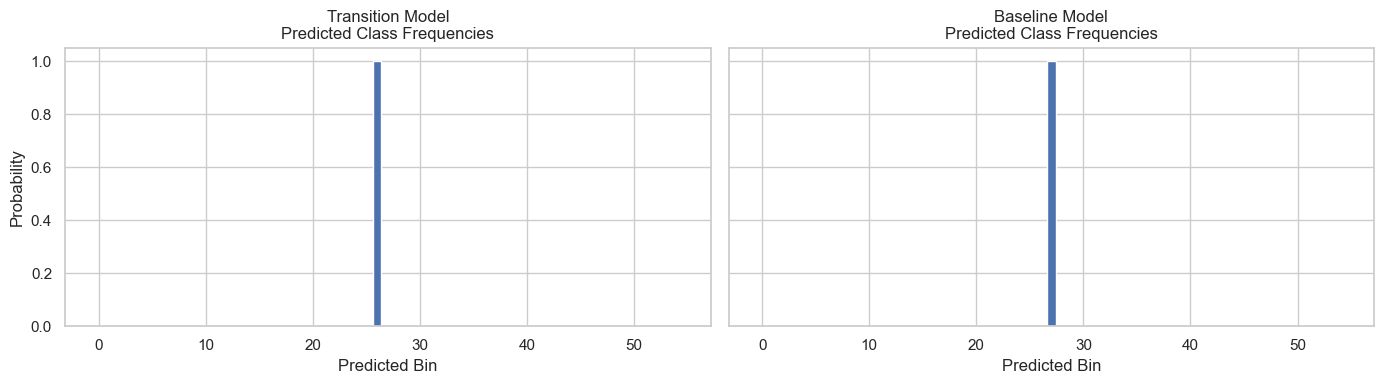

Transition dominant bin: 26
Baseline dominant bin:   27


In [19]:
# --------------------------------------------------
# Predicted Class Frequency Comparison
# --------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

# Count predicted bins
counts_transition = np.bincount(y_pred_transition, minlength=n_states)
counts_baseline   = np.bincount(y_pred_baseline,   minlength=n_states)

# Normalize to probabilities (optional but cleaner)
freq_transition = counts_transition / counts_transition.sum()
freq_baseline   = counts_baseline   / counts_baseline.sum()

bins = np.arange(n_states)

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

axes[0].bar(bins, freq_transition)
axes[0].set_title("Transition Model\nPredicted Class Frequencies")
axes[0].set_xlabel("Predicted Bin")
axes[0].set_ylabel("Probability")

axes[1].bar(bins, freq_baseline)
axes[1].set_title("Baseline Model\nPredicted Class Frequencies")
axes[1].set_xlabel("Predicted Bin")

plt.tight_layout()
plt.show()

# Print dominant bins (helps interpretation)
print("Transition dominant bin:", np.argmax(freq_transition))
print("Baseline dominant bin:  ", np.argmax(freq_baseline))
